In [67]:
import numpy as np
from numpy import linalg as LA
import math as m
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing default values
import scipy.io as sio
from scipy.optimize import minimize
import timeit
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint

## Example Convolutional NN: A-C

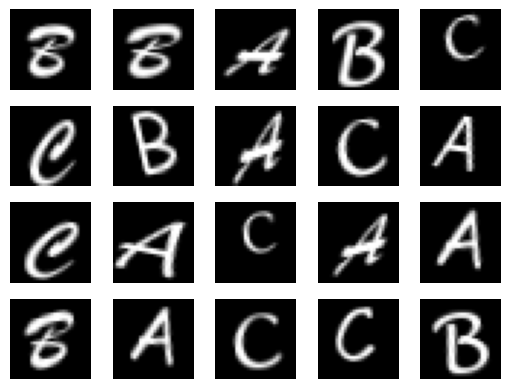

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
#conda install -c pytorch torchvision  #need this package
#from torchvision import transforms, datasets
import random
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
torch.manual_seed(0)

# Load the dataset
mat_file=sio.loadmat('DATA/lettersTrainSetME.mat')
TTrain=mat_file['TTrainA']
TTrain=TTrain-1  #=>Letter A = 0, B=1, C=2
XTrain=mat_file['XTrain'] #Greyscale 28x28x1x1500

mat_file=sio.loadmat('DATA/lettersTestSetME.mat')
TTest=mat_file['TTestA'] #Greyscale 28x28x1x1500
XTest=mat_file['XTest']  #=> Letter A = 0, B=1, C=2
TTest=TTest-1 

#Make an random choice of 20 letters
perm = np.random.permutation(1500)[:20]


fig,axs = plt.subplots(4,5)
axs = axs.reshape(-1)

for j in range(len(axs)):
    axs[j].imshow(np.squeeze(XTrain[:,:,:,perm[j]]),cmap='gray')
    axs[j].axis('off')

In [69]:
import torch
import torch.nn as nn



# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # - Input: 1 channel (grayscale image), Output: 16 channels, Kernel Size: 5x5
        # - This layer extracts 16 different features using 5x5 convolutional filters.
        
        self.relu = nn.ReLU()
        # - ReLU activation function is applied after convolution to introduce non-linearity.
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # - Max pooling layer reduces the spatial dimensions (height and width) by a factor of 2.
        
        self.fc1 = nn.Linear(16 * 12 * 12, 3)
        # - Fully connected layer with 16*12*12 input features and 3 output features.
        # - The input size matches the output size of the last convolutional layer.
        # - The 3 output features correspond to the classes in your classification problem.
        
        self.softmax = nn.Softmax(dim=1)
        # - Softmax activation function is applied to produce class probabilities.

    def forward(self, x):
        # Forward propagation through the network
        
        x = self.pool(self.relu(self.conv1(x)))
        # - Apply the first convolution, ReLU activation, and max pooling.
        
        x = x.view(-1, 16 * 12 * 12)
        # - Reshape the 4D tensor (batch_size, channels, height, width) into a 2D tensor.
        
        x = self.softmax(self.fc1(x))
        # - Apply the fully connected layer and softmax activation to get class probabilities.
        
        return x

net = Net()  # Create an instance of the neural network.

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# - Cross-Entropy Loss is commonly used for classification problems.
# - It measures the dissimilarity between predicted class probabilities and true labels.

optimizer = optim.SGD(net.parameters(), lr=0.001)
# - Stochastic Gradient Descent (SGD) optimizer is used for training.
# - It updates the network's parameters to minimize the loss during training.
# - Learning rate (lr) controls the step size in parameter updates.
# Training loop
for epoch in range(1000):  # Increase the number of epochs as needed
    running_loss = 0.0
    for i in range(len(perm)):
        inputs = torch.tensor(XTrain[:, :, 0, perm[i]], dtype=torch.float32)  # Convert to float32
        labels = torch.tensor(TTrain[perm[i]].astype(np.int64))  # Convert to int64
        optimizer.zero_grad()
        outputs = net(inputs.unsqueeze(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

print('Finished Training')
print(outputs)


Finished Training
tensor([[1.8809e-05, 9.9963e-01, 3.4660e-04]], grad_fn=<SoftmaxBackward0>)


In [70]:

# Set the model in evaluation mode
net.eval()

# Initialize variables to keep track of correct predictions and total samples
correct = 0
total = 0

# Check model prediction vs test dataset
for i in range(len(TTest)):
    inputs = torch.tensor(XTest[:, :, 0, i], dtype=torch.float32)  # Convert to float32
    labels = torch.tensor(TTest[i].astype(np.int64))  # Convert to int64
    outputs = net(inputs.unsqueeze(0))  # Add batch dimension

    # Get the predicted class label
    _, predicted = torch.max(outputs, 1)

    # Update total count
    total += labels.size(0)

    # Check if the prediction matches the true label
    #print(predicted)
    correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total

print(f'Test Accuracy: {accuracy:.2f}%')

# Set the model back to training mode
net.train()

model_state_dict = net.state_dict()
print(model_state_dict)

Test Accuracy: 82.13%
OrderedDict({'conv1.weight': tensor([[[[ 1.1704e-02,  1.1878e-01, -1.6997e-01, -1.6053e-01, -8.7832e-02],
          [ 6.5691e-02,  9.0572e-03,  1.5434e-01, -2.6596e-02,  4.7375e-02],
          [-4.7723e-02, -2.3738e-02, -1.8646e-01, -1.3113e-01, -8.4317e-02],
          [ 2.3520e-02,  1.0173e-01,  1.3803e-01, -1.2797e-01, -8.7474e-02],
          [ 9.0673e-02,  1.9203e-01, -2.0142e-02,  1.5872e-01, -3.4979e-02]]],


        [[[ 2.8920e-02,  1.8939e-01, -1.8096e-01, -1.2604e-01, -5.0756e-02],
          [-7.6842e-02,  1.8421e-01, -1.2069e-01, -9.0956e-02, -1.3972e-01],
          [-1.8740e-01, -1.0849e-01,  1.8259e-01,  9.5169e-02,  1.0144e-01],
          [ 1.2844e-02, -9.1702e-02,  4.9051e-02, -1.7944e-01, -1.4108e-01],
          [-9.7332e-02,  1.4313e-01,  1.3074e-01, -8.7416e-02, -1.0982e-02]]],


        [[[ 1.5979e-01,  2.2916e-01,  1.0518e-01,  5.8942e-02,  1.5991e-01],
          [-9.9595e-02,  5.9113e-02, -1.1901e-01, -9.0565e-02, -6.7659e-02],
          [ 1.007

## Recurrent NN

In [71]:
import torch.nn as nn

class MinimalStateCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MinimalStateCell, self).__init__()
        self.hidden_size = hidden_size
        self.W_u = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)
        u_t = torch.sigmoid(self.W_u(combined))
        c_tilde = torch.tanh(self.W_c(combined))
        c_t = u_t * c_tilde + (1 - u_t) * c_prev
        h_t = torch.tanh(c_t)
        return h_t, c_t
    

class MSCSequenceModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(MSCSequenceModel, self).__init__()
        self.hidden_size = hidden_size
        self.cell = MinimalStateCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x_seq):
        # x_seq: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x_seq.shape
        h = torch.zeros(batch_size, self.hidden_size)
        c = torch.zeros(batch_size, self.hidden_size)
        outputs = []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]  # shape (batch, input_size)
            h, c = self.cell(x_t, h, c)
            out = self.output_layer(h)
            outputs.append(out.unsqueeze(1))  # (batch, 1, output_size)

        return torch.cat(outputs, dim=1)  # shape: (batch, seq_len, output_size)


In [72]:
x = np.linspace(0, 10, 100).astype(np.float32)
y = np.sin(x).astype(np.float32)

# shape to (batch=1, seq_len=100, input_size=1)
X_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(-1)  # (1, 100, 1)
Y_tensor = torch.from_numpy(y).unsqueeze(0).unsqueeze(-1)  # (1, 100, 1)

model = MSCSequenceModel(input_size=1, hidden_size=6, output_size=1)

In [73]:

criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=0.01)

epochs = 4000
loss_history = []
loss_test_history = []
epoch_ticks = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_tensor)                  # (1,100,1)
    loss = criterion(preds, Y_tensor)        # shapes match
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Loss {loss.item():.6f}")

# If you only want the last-step prediction:
# last_pred = preds[:, -1, :]  # (batch, output_size)
# last_target = Y_tensor[:, -1, :]

Epoch    0 | Loss 0.513076
Epoch  100 | Loss 0.333173
Epoch  200 | Loss 0.067505
Epoch  300 | Loss 0.211454
Epoch  400 | Loss 0.052094
Epoch  500 | Loss 0.035526
Epoch  600 | Loss 0.020335
Epoch  700 | Loss 0.010518
Epoch  800 | Loss 0.006036
Epoch  900 | Loss 0.004214
Epoch 1000 | Loss 0.003324
Epoch 1100 | Loss 0.002792
Epoch 1200 | Loss 0.002425
Epoch 1300 | Loss 0.002136
Epoch 1400 | Loss 0.001881
Epoch 1500 | Loss 0.001637
Epoch 1600 | Loss 0.001397
Epoch 1700 | Loss 0.001168
Epoch 1800 | Loss 0.000964
Epoch 1900 | Loss 0.000797
Epoch 2000 | Loss 0.010322
Epoch 2100 | Loss 0.000656
Epoch 2200 | Loss 0.000555
Epoch 2300 | Loss 0.000480
Epoch 2400 | Loss 0.002980
Epoch 2500 | Loss 0.000545
Epoch 2600 | Loss 0.000469
Epoch 2700 | Loss 0.000408
Epoch 2800 | Loss 0.000357
Epoch 2900 | Loss 0.006397
Epoch 3000 | Loss 0.000333
Epoch 3100 | Loss 0.000291
Epoch 3200 | Loss 0.000419
Epoch 3300 | Loss 0.002009
Epoch 3400 | Loss 0.000250
Epoch 3500 | Loss 0.000680
Epoch 3600 | Loss 0.000366
E

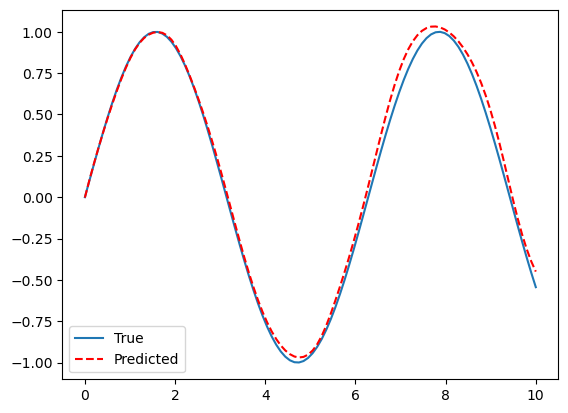

In [74]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor)  # (1, seq_len, 1)
    preds = preds.squeeze(0).squeeze(-1).cpu().numpy()  # (seq_len,)

plt.plot(x,y,label='True')
plt.plot(x,preds,'r--',label='Predicted')
plt.legend()

In [75]:


# Sequence 1
x1 = np.linspace(0, 10, 100).astype(np.float32)
x2 = np.ones(100, dtype=np.float32)
X_seq1 = np.column_stack((x1, x2))    # (100, 2)
y1 = np.sin(x1).astype(np.float32)

# Sequence 2
x1b = np.linspace(0, 10, 100).astype(np.float32)
x2b = 2.*np.ones(100, dtype=np.float32)
X_seq2 = np.column_stack((x1b, x2b))  # (100, 2)
y2 = 2.**2*np.sin(x1b).astype(np.float32)

# Sequence 3
x1c = np.linspace(0, 10, 100).astype(np.float32)
x2c = 3*np.ones(100, dtype=np.float32)
X_seq3 = np.column_stack((x1c, x2c))  # (100, 2)
y3 = 3.**2*np.sin(x1c).astype(np.float32)

# Stack into one batch: (batch=3, seq_len=100, features=2)
X_batch = np.stack([X_seq1, X_seq2, X_seq3], axis=0)
Y_batch = np.stack([y1, y2, y3], axis=0)[..., None]  # add last dim for output size=1

# Convert to torch tensors
X_tensor = torch.from_numpy(X_batch).float()   # (3, 100, 2)
Y_tensor = torch.from_numpy(Y_batch).float()   # (3, 100, 1)

print(X_tensor.shape)  # torch.Size([3, 100, 2])
print(Y_tensor.shape)  # torch.Size([3, 100, 1])

model = MSCSequenceModel(input_size=2, hidden_size=6, output_size=1)

torch.Size([3, 100, 2])
torch.Size([3, 100, 1])


In [76]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 8000
loss_history = []
loss_test_history = []
epoch_ticks = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_tensor)                  # (1,100,1)
    loss = criterion(preds, Y_tensor)        # shapes match
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Loss {loss.item():.6f}")

Epoch    0 | Loss 15.154417
Epoch  100 | Loss 6.745976
Epoch  200 | Loss 3.804763
Epoch  300 | Loss 3.428474
Epoch  400 | Loss 3.551929
Epoch  500 | Loss 2.752920
Epoch  600 | Loss 2.718469
Epoch  700 | Loss 2.604612
Epoch  800 | Loss 2.571166
Epoch  900 | Loss 2.547975
Epoch 1000 | Loss 2.531469
Epoch 1100 | Loss 2.518014
Epoch 1200 | Loss 2.521734
Epoch 1300 | Loss 2.490291
Epoch 1400 | Loss 2.485507
Epoch 1500 | Loss 2.483426
Epoch 1600 | Loss 2.477496
Epoch 1700 | Loss 2.475857
Epoch 1800 | Loss 2.456753
Epoch 1900 | Loss 2.454060
Epoch 2000 | Loss 2.448305
Epoch 2100 | Loss 2.445218
Epoch 2200 | Loss 2.440975
Epoch 2300 | Loss 2.437187
Epoch 2400 | Loss 2.433732
Epoch 2500 | Loss 2.429769
Epoch 2600 | Loss 2.422458
Epoch 2700 | Loss 2.401894
Epoch 2800 | Loss 2.348333
Epoch 2900 | Loss 2.234702
Epoch 3000 | Loss 2.064861
Epoch 3100 | Loss 1.289793
Epoch 3200 | Loss 2.627215
Epoch 3300 | Loss 1.358335
Epoch 3400 | Loss 1.173771
Epoch 3500 | Loss 9.019711
Epoch 3600 | Loss 2.603006


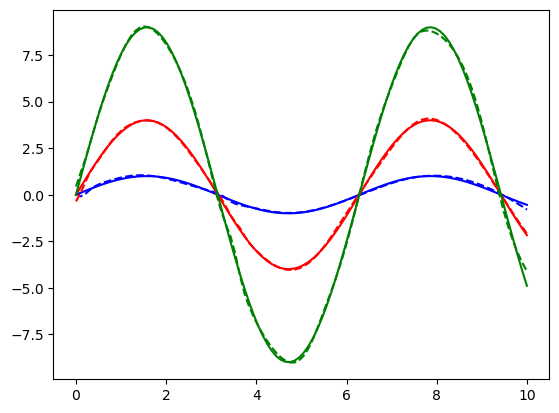

In [77]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor)  # (3, seq_len, 1)
    preds = preds.squeeze(0).squeeze(-1).numpy()  # (seq_len,)

plt.plot(x1,y1,'b',label='True')
plt.plot(x1,preds[0,:],'b--',label='Predicted')
plt.plot(x1b,y2,'r',label='True')
plt.plot(x1b,preds[1,:],'r--',label='Predicted')
plt.plot(x1c,y3,'g',label='True')
plt.plot(x1c,preds[2,:],'g--',label='Predicted')


#plt.legend()
plt.show()

## Prediction 1 (in time)

In [ ]:
# Sequence 1
x1 = np.linspace(0, 20, 200).astype(np.float32)
x2 = np.ones(200, dtype=np.float32)
X_seq1 = np.column_stack((x1, x2))    # (100, 2)


# Sequence 2
x1b = np.linspace(0, 20, 200).astype(np.float32)
x2b = 2.*np.ones(200, dtype=np.float32)
X_seq2 = np.column_stack((x1b, x2b))  # (100, 2)


# Sequence 3
x1c = np.linspace(0, 20, 200).astype(np.float32)
x2c = 3*np.ones(200, dtype=np.float32)
X_seq3 = np.column_stack((x1c, x2c))  # (100, 2)


# Stack into one batch: (batch=3, seq_len=100, features=2)
X_batch = np.stack([X_seq1, X_seq2, X_seq3], axis=0)
Y_batch = np.stack([y1, y2, y3], axis=0)[..., None]  # add last dim for output size=1

# Convert to torch tensors
X_tensor = torch.from_numpy(X_batch).float()   # (3, 200, 2)

model.eval()
with torch.no_grad():
    preds = model(X_tensor)  # (3, seq_len, 1)
    preds = preds.squeeze(0).squeeze(-1).numpy()  # (seq_len,)

#plt.plot(x1,y1,'b',label='True')
plt.plot(x1,preds[0,:],'b--',label='Predicted')
#plt.plot(x1b,y2,'r',label='True')
plt.plot(x1b,preds[1,:],'r--',label='Predicted')
#plt.plot(x1c,y3,'g',label='True')
plt.plot(x1c,preds[2,:],'g--',label='Predicted')


## Prediction for another x2


In [ ]:
x1p = np.linspace(0, 10, 100).astype(np.float32)
x2p = 2.5*np.ones(100, dtype=np.float32)
X_seqp = np.column_stack((x1p, x2p))    # (100, 2)
y1p = 2.5**2*np.sin(x1p).astype(np.float32)

#
# Stack into one batch: (batch=3, seq_len=100, features=2)
X_batch = np.stack([X_seqp], axis=0)


# Convert to torch tensors
X_tensor = torch.from_numpy(X_batch).float()   # (1, 100, 2)
model.eval()
with torch.no_grad():
    preds_p = model(X_tensor)  # (3, seq_len, 1)
    preds_p = preds_p.squeeze(0).squeeze(-1).numpy()  # (seq_len,)

plt.plot(x1p,y1p,'m',label='True')
plt.plot(x1p,preds_p,'m--',label='Predicted')
# plt.plot(x1,y1,'b',label='True')


In [ ]:
# plt.plot(x1,preds[0,:],'b--',label='Predicted')
# plt.plot(x1b,y2,'r',label='True')
# plt.plot(x1b,preds[1,:],'r--',label='Predicted')
# plt.plot(x1c,y3,'g',label='True')
# plt.plot(x1c,preds[2,:],'g--',label='Predicted')


## Example of classification 

In [84]:
#import torch
#import torch.nn as nn
#import torch.optim as optim
#import numpy as np

# Generate synthetic data
np.random.seed(0)
num_samples = 100
num_features = 2

class_0 = np.random.randn(num_samples // 2, num_features) + np.array([-1, -1])  #random numers around -1,-1
class_1 = np.random.randn(num_samples // 2, num_features) + np.array([1, 1])    #random numers around 1,1


x = np.vstack((class_0, class_1))
y=np.zeros((num_samples,2))
y[0:num_samples//2,0]=1.
y[num_samples//2:,1]=1.


print(f'x= {x}')
print(f'y= {y}')


x= [[ 7.64052346e-01 -5.99842792e-01]
 [-2.12620159e-02  1.24089320e+00]
 [ 8.67557990e-01 -1.97727788e+00]
 [-4.99115825e-02 -1.15135721e+00]
 [-1.10321885e+00 -5.89401498e-01]
 [-8.55956429e-01  4.54273507e-01]
 [-2.38962275e-01 -8.78324984e-01]
 [-5.56136767e-01 -6.66325673e-01]
 [ 4.94079073e-01 -1.20515826e+00]
 [-6.86932298e-01 -1.85409574e+00]
 [-3.55298982e+00 -3.46381405e-01]
 [-1.35563801e-01 -1.74216502e+00]
 [ 1.26975462e+00 -2.45436567e+00]
 [-9.54241483e-01 -1.18718385e+00]
 [ 5.32779214e-01  4.69358770e-01]
 [-8.45052574e-01 -6.21837480e-01]
 [-1.88778575e+00 -2.98079647e+00]
 [-1.34791215e+00 -8.43651031e-01]
 [ 2.30290681e-01  2.02379849e-01]
 [-1.38732682e+00 -1.30230275e+00]
 [-2.04855297e+00 -2.42001794e+00]
 [-2.70627019e+00  9.50775395e-01]
 [-1.50965218e+00 -1.43807430e+00]
 [-2.25279536e+00 -2.22509644e-01]
 [-2.61389785e+00 -1.21274028e+00]
 [-1.89546656e+00 -6.13097502e-01]
 [-1.51080514e+00 -2.18063218e+00]
 [-1.02818223e+00 -5.71668129e-01]
 [-9.33482778e-01

In [85]:

# Randomly shuffle the data
np.random.seed(0) # for getting out the same random variables every time (reproducability)
indices = np.random.permutation(num_samples)
# Split the dataset into training and testing sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(num_samples * split_ratio)

# Split the data based on the shuffled indices
x_train, x_test = x[indices[:split_index],:], x[indices[split_index:],:]
y_train, y_test = y[indices[:split_index],:], y[indices[split_index:],:]

print('x_train=',x_train[0:10,:])
print('y_train=',y_train[0:10,:])

x_train= [[-1.51080514 -2.18063218]
 [ 1.85683061  0.34897441]
 [ 0.86755799 -1.97727788]
 [ 2.86755896  1.90604466]
 [ 0.93175839  2.71334272]
 [-0.10438334  1.05216508]
 [-1.88778575 -2.98079647]
 [ 0.08717777  2.11701629]
 [ 2.92294203  2.48051479]
 [-0.29285691  1.26705087]]
y_train= [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [86]:


# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Convert data to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = num_features
output_size = 2  # Number of classes
model = SimpleNN(input_size, output_size)
criterion = nn.CrossEntropyLoss()   #here comes cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_tensor)
    probabilities=torch.softmax(outputs, dim=1)   #here comes softmax function 
    loss = criterion(probabilities, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [100/10000], Loss: 0.3914
Epoch [200/10000], Loss: 0.3892
Epoch [300/10000], Loss: 0.3878
Epoch [400/10000], Loss: 0.3867
Epoch [500/10000], Loss: 0.3858
Epoch [600/10000], Loss: 0.3851
Epoch [700/10000], Loss: 0.3844
Epoch [800/10000], Loss: 0.3839
Epoch [900/10000], Loss: 0.3834
Epoch [1000/10000], Loss: 0.3829
Epoch [1100/10000], Loss: 0.3825
Epoch [1200/10000], Loss: 0.3821
Epoch [1300/10000], Loss: 0.3817
Epoch [1400/10000], Loss: 0.3813
Epoch [1500/10000], Loss: 0.3810
Epoch [1600/10000], Loss: 0.3807
Epoch [1700/10000], Loss: 0.3804
Epoch [1800/10000], Loss: 0.3802
Epoch [1900/10000], Loss: 0.3799
Epoch [2000/10000], Loss: 0.3797
Epoch [2100/10000], Loss: 0.3795
Epoch [2200/10000], Loss: 0.3793
Epoch [2300/10000], Loss: 0.3791
Epoch [2400/10000], Loss: 0.3789
Epoch [2500/10000], Loss: 0.3788
Epoch [2600/10000], Loss: 0.3786
Epoch [2700/10000], Loss: 0.3785
Epoch [2800/10000], Loss: 0.3783
Epoch [2900/10000], Loss: 0.3782
Epoch [3000/10000], Loss: 0.3781
Epoch [3100/10000],

In [87]:

# Model evaluation
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    probabilities=torch.softmax(outputs, dim=1)
    predicted_classes=torch.argmax(probabilities, dim=1)
    test_classes=torch.argmax(y_test_tensor, dim=1)
accuracy = torch.sum(predicted_classes == test_classes).item() / y_test_tensor.size(0)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.00%


## Example Lorenz ODE system

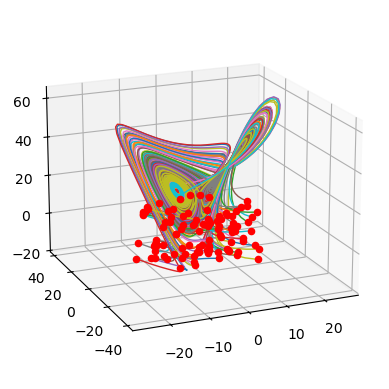

In [83]:
from scipy import integrate
## Simulate the Lorenz System
dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)   #sampling time 0.01, gives 801 timesteps
beta = 8/3
sigma = 10
rho = 28

#define sizes of input and output matrices
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))  #100 different initial conditions

#x_t: 100 x 801 x 3
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])   #here the ode is solved for all initial conditions

#save to input and output matrices
m=0
for j in range(100): #loop over initial conditions
    #nn_input 80000 x 3
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,0:800,:] #x_t[j,:-1,:]
    #nn_output 80000 x 3
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:801,:] #x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [19]:
# Convert data to PyTorch tensors
nn_input = torch.tensor(nn_input, dtype=torch.float32).clone().detach()
nn_output = torch.tensor(nn_output, dtype=torch.float32).clone().detach()

# Define custom activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x
# Define a custom neural network class using PyTorch's nn.Module
class CustomNet(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(CustomNet, self).__init__()

        # Define the layers of the neural network
        # The neural network architecture consists of three linear layers.
        # Each linear layer performs a linear transformation (matrix multiplication) on its input.
        # These layers are connected sequentially.

        # Layer 1:
        #   - in_features: Number of input features, inferred from nn_input.shape[1]
        #   - out_features: Number of output features (neurons) in this layer, set to 10
        self.layer1 = nn.Linear(in_features=nn_input.shape[1], out_features=10)

        # Layer 2:
        #   - in_features: Number of input features, which is the number of output features from Layer 1
        #   - out_features: Number of output features (neurons) in this layer, set to 10
        self.layer2 = nn.Linear(in_features=10, out_features=10)

        # Layer 3:
        #   - in_features: Number of input features, which is the number of output features from Layer 2
        #   - out_features: Number of output features (neurons) in this layer, set to 3
        #     
        self.layer3 = nn.Linear(in_features=10, out_features=3)  # 3 output features

    def forward(self, x):
        # Define the forward pass of the neural network
        # This method describes how data flows through the network's layers.

        # Layer 1:
        #   - Apply a custom activation function (logsig) to the output of Layer 1
        #   - The result is assigned to 'x', effectively replacing the input 'x'
        x = logsig(self.layer1(x))

        # Layer 2:
        #   - Apply a custom activation function (radbas) to the output of Layer 2
        #   - The result is assigned to 'x', effectively replacing the previous 'x'
        x = radbas(self.layer2(x))

        # Layer 3:
        #   - Apply a custom activation function (purelin) to the output of Layer 3
        #   - The result is assigned to 'x', effectively replacing the previous 'x'
        x = purelin(self.layer3(x))

        # Return the final output 'x', which represents the predictions of the neural network
        return x


# Instantiate the custom neural network
model = CustomNet()

# Define the optimizer
adam_optimizer = optim.Adam(model.parameters(), lr=0.01) #, weight_decay=0.00001)  #optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the loss function (use Mean Squared Error for regression)
criterion = nn.MSELoss()

# Training loop
num_epochs = 800
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(nn_input)
    
    # Calculate the loss
    loss = criterion(outputs, nn_output)
    
    # Backpropagation and optimization
    adam_optimizer.zero_grad()
    loss.backward()
    adam_optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

C:\Users\magnu\AppData\Local\Temp\ipykernel_2064\2902902357.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nn_input = torch.tensor(nn_input, dtype=torch.float32).clone().detach()
C:\Users\magnu\AppData\Local\Temp\ipykernel_2064\2902902357.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nn_output = torch.tensor(nn_output, dtype=torch.float32).clone().detach()


Epoch [100/800], Loss: 146.1281
Epoch [200/800], Loss: 69.3056
Epoch [300/800], Loss: 33.8382
Epoch [400/800], Loss: 18.3939
Epoch [500/800], Loss: 11.4958
Epoch [600/800], Loss: 8.1788
Epoch [700/800], Loss: 6.2236
Epoch [800/800], Loss: 4.9388


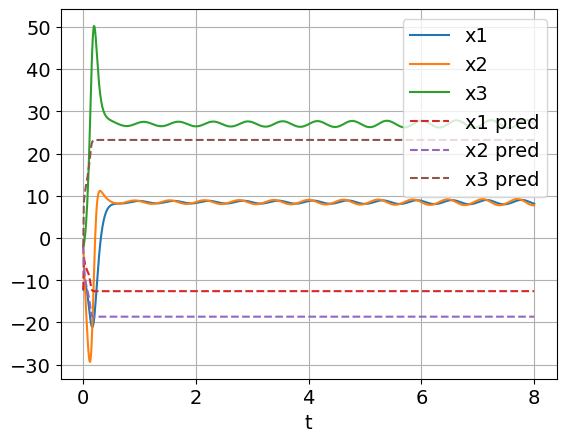

In [20]:
fig, ax = plt.subplots()
rcParams["font.size"] = 14

ax.plot(t,x_t[10,:,0],linestyle='-',label='x1')
ax.plot(t,x_t[10,:,1],linestyle='-',label='x2')
ax.plot(t,x_t[10,:,2],linestyle='-',label='x3')
ax.set_xlabel('t')


ax.grid(visible=True)




# Set the model to evaluation mode
model.eval()
#choose for example 10th initial value x0
xx=torch.tensor(x0[10,:], dtype=torch.float32).clone().detach()
xpred=np.zeros((len(t),3))
#loop over time
for i in range(len(t)):
    xpred[i,:]=xx.numpy()
    with torch.no_grad():
        predictions = model(xx)
    xx=predictions
    
ax.plot(t,xpred[:,0],linestyle='--',label='x1 pred')
ax.plot(t,xpred[:,1],linestyle='--',label='x2 pred')
ax.plot(t,xpred[:,2],linestyle='--',label='x3 pred')
ax.legend(loc='best')
plt.show()
#predictions = model
# Forward pass to get predictions


# If you need to convert predictions to a numpy array:
#predictions = predictions.numpy()

#print(predictions)